## **MÉTODOS DE ENSAMBLE**

Continuaremos con las técnicas de ensamble. En esta práctica veremos **boosting**.

- - -

## **`BOOSTING`**

Al igual que en la técnica *bagging*, aquí la predicción final se hace votando. La diferencia radica en cómo llegamos a cada modelo que compone el ensamble.

*Boosting* es una técnica que trabaja entrenando modelos de manera iterativa en base a los errores del modelo anterior.

Existe una suerte de especialización a medida que avanza el entrenamiento. La clave está en **pesar** las instancias (darles mayor importancia), de acuerdo a lo difícil que son de clasificar, y recompensar a los clasificadores en función del peso de los ejemplos que aciertan. Es decir, en ese proceso iterativo, se va aumentando el peso de las instancias mal clasificadas previamente.

En boosting cada árbol es entrenado secuencialmente  -uno después del otro, por lo que están relacionados-, mientras que en bagging son entrenados de manera independiente -paralela-. Ambas técnicas modifican el set de entrenamiento, una por muestreo y la otra por asignación de pesos.

En bagging, cada árbol suele ser profundo -están sobreajustados o tienen mucha varianza, pero poco sesgo-. El ensamble combina modelos de mucha varianza para disminuirla.

En boosting, cada árbol suele ser poco profundo -están subajustados o sesgados, pero tienen poca varianza-. El ensamble combina modelos sesgados para obtener uno no sesgado.

Boosting tiene tres hiperparámetros principales:

+ Número de árboles

+ Tasa de aprendizaje

+ Profundidad de cada árbol

Veremos la implementación de esta técnica con el algoritmo `XGBoost`. Aquí, el problema de optimización se resuelve utilizando descenso por gradiente. Es uno de los modelos más empleados en la materia. Tiene una buena performance computacional. No viene incorporado con Scikit-learn. 

<img src = "https://miro.medium.com/max/910/1*nZIFUJv5zwuVTh1tHaYFkg.png" height = 350>

*Diferencia entre los métodos bagging y boosting*.

- - -

### `Práctica`

Seguiremos trabajando con el [dataset](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) de la Práctica_01.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics

from sklearn.model_selection import learning_curve

In [2]:
data = pd.read_csv('..\Datasets\Clase_08_weatherAUS.csv')
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# Dropeamos columnas con muchos faltantes
columnas_descartables = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','Date']
data = data.drop(columns=columnas_descartables)
data = data.dropna()

# Dropeamos las columnas categóricas para facilitar el análisis
columnas_descartables = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']
data = data.drop(columns=columnas_descartables)

# Variables que dropeamos a partir del mapa de calor
data = data.drop(columns=['Temp3pm', 'Pressure9am'])

# Mapeamos la variable de salida
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1,'No':0})

In [4]:
data.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Temp9am,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.1,16.9,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1007.8,17.2,0
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1008.7,21.0,0
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1012.8,18.1,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1006.0,17.8,0


In [5]:
#import sys
#!{sys.executable} -m pip install xgboost
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

In [6]:
# Elegimos las columnas predictoras

columnas_entrenamiento = ['MaxTemp', 'Humidity3pm']
X = data[columnas_entrenamiento]
y = data.RainTomorrow

# Separamos los datos en train y test (hold-out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

In [14]:
# Instanciamos el modelo

clf_xgb = xgb.XGBClassifier(n_estimators=500,
                            seed=42)
                            
# Entrenamos
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [15]:
# Predecimos

y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)

# Evaluamos
print('Accuracy en train:', metrics.accuracy_score(y_train, y_train_pred))
print('Accuracy en test:', metrics.accuracy_score(y_test, y_test_pred))

Accuracy en train: 0.8427264791832707
Accuracy en test: 0.8272625302556231


**Pasemos a plotear las fronteras de decisión**.

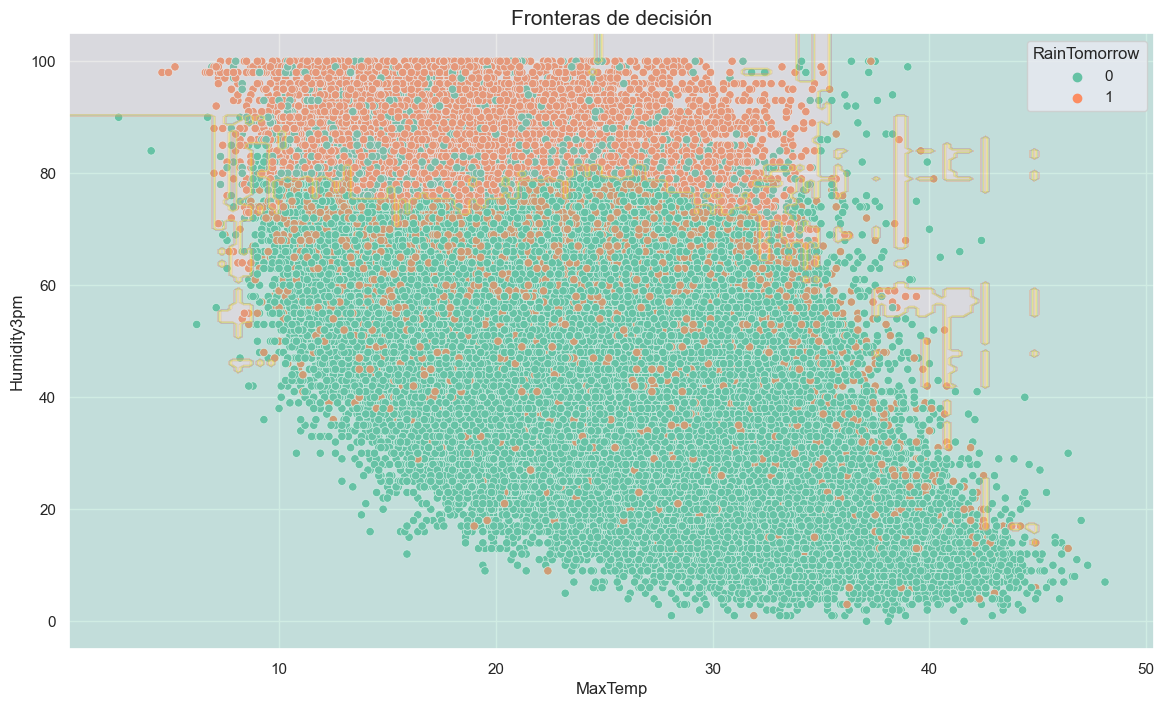

In [13]:
# Fronteras de decisión

N = 20 

plt.figure(figsize = (14,8))

ax = sns.scatterplot(x = X_train['MaxTemp'], y = X_train['Humidity3pm'], hue = y_train, palette = 'Set2') 
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = clf_xgb.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.title('Fronteras de decisión', fontsize = 15)

plt.show()

- - -

In [10]:
# graficar fronteras de decisión para los siguientes clasificadores: XGBOOSt

